#Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, InputLayer, Dropout, LSTM, Bidirectional
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

import seaborn as sn
import matplotlib.pyplot as plt

import warnings

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam

import re
import string

import requests

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Importing Glove

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-10-31 16:38:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-10-31 16:38:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-10-31 16:38:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  train.csv
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [7]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [8]:
nlp = spacy.load("en_core_web_sm")

#Importing data

In [9]:
df = pd.read_csv('/content/train.csv')

#Data analysis

In [10]:
df.shape

(159571, 8)

In [11]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [12]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**checking for null values**

In [13]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

**There are no null values so we can proceed**

In [14]:
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [15]:
df['severe_toxic'].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [16]:
df['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [17]:
df['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [18]:
df['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [19]:
df['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

#Data Visulalization

**Counting number of comments of each category**

In [20]:
selected_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

melted_df = pd.melt(df[selected_columns],var_name='Category',value_name='Count')

melted_df['Category'][melted_df['Count']==1].value_counts(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
Name: Category, dtype: int64

In [21]:
melted_df.head()

,Category,Count
0,toxic,0
1,toxic,0
2,toxic,0
3,toxic,0
4,toxic,0


<Axes: xlabel='Category', ylabel='count'>

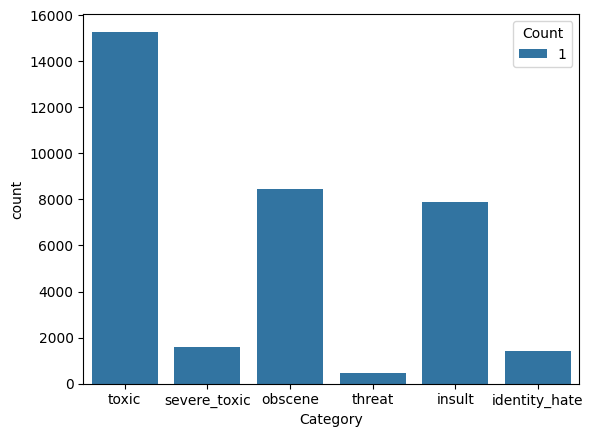

In [22]:
sn.countplot(x='Category',data=melted_df[melted_df['Count']==1],hue='Count')

In [23]:
data = df.set_index('id')
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#Tokenization

In [24]:
data['comment_text'] = data['comment_text'].apply(word_tokenize)

In [25]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"[Explanation, Why, the, edits, made, under, my...",0,0,0,0,0,0
000103f0d9cfb60f,"[D'aww, !, He, matches, this, background, colo...",0,0,0,0,0,0
000113f07ec002fd,"[Hey, man, ,, I, 'm, really, not, trying, to, ...",0,0,0,0,0,0
0001b41b1c6bb37e,"[``, More, I, ca, n't, make, any, real, sugges...",0,0,0,0,0,0
0001d958c54c6e35,"[You, ,, sir, ,, are, my, hero, ., Any, chance...",0,0,0,0,0,0


In [26]:
data.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
ffe987279560d7ff,"[``, :, :, :, :, :, And, for, the, second, tim...",0,0,0,0,0,0
ffea4adeee384e90,"[You, should, be, ashamed, of, yourself, That,...",0,0,0,0,0,0
ffee36eab5c267c9,"[Spitzer, Umm, ,, theres, no, actual, article,...",0,0,0,0,0,0
fff125370e4aaaf3,"[And, it, looks, like, it, was, actually, you,...",0,0,0,0,0,0
fff46fc426af1f9a,"[``, And, ..., I, really, do, n't, think, you,...",0,0,0,0,0,0


#Wordcloud

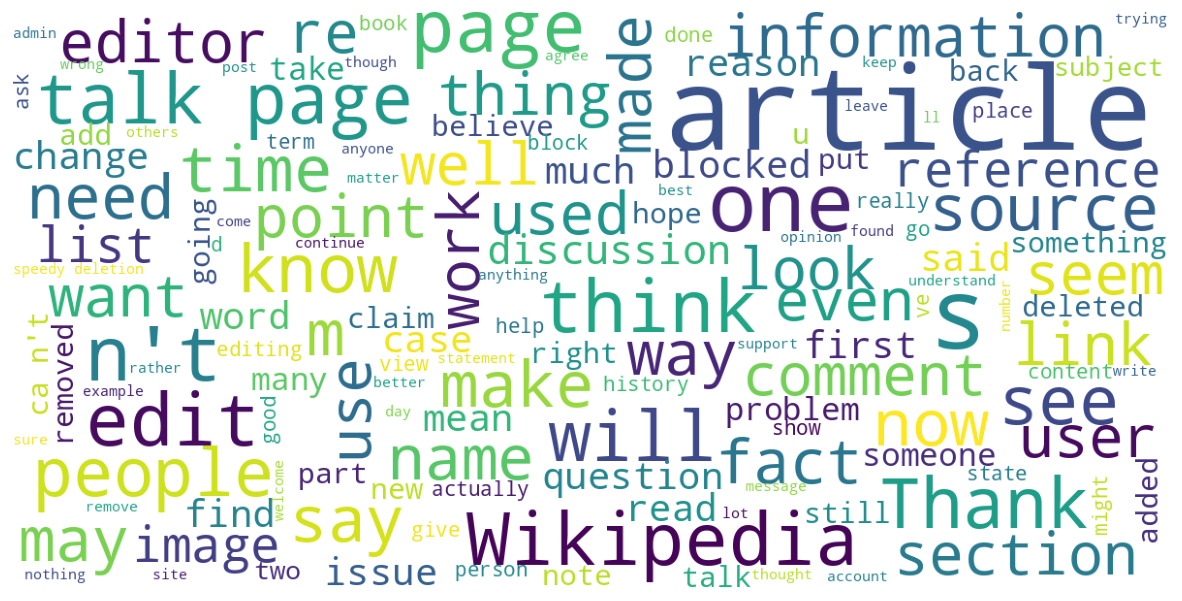

In [27]:
X = []

for word in data['comment_text']:
  X.append(' '.join(word))

wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(X))

fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

#Removing punctuations/Numeric data

In [28]:
def remove_punctuation(text):
    # Use regular expressions to remove punctuation

    s = str(' '.join(text))

    tmp = re.sub(f"[{re.escape(string.punctuation)}]", "", s)
    tmp = re.sub(r'\d+','',tmp)

    ans = list(tmp.split(' '))

    return ans

In [29]:
data['comment_text'] = data['comment_text'].apply(remove_punctuation)

In [30]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"[Explanation, Why, the, edits, made, under, my...",0,0,0,0,0,0
000103f0d9cfb60f,"[Daww, , He, matches, this, background, colour...",0,0,0,0,0,0
000113f07ec002fd,"[Hey, man, , I, m, really, not, trying, to, ed...",0,0,0,0,0,0
0001b41b1c6bb37e,"[, More, I, ca, nt, make, any, real, suggestio...",0,0,0,0,0,0
0001d958c54c6e35,"[You, , sir, , are, my, hero, , Any, chance, y...",0,0,0,0,0,0


In [31]:
def remove_length2(text):
  s = [word for word in text if len(word)>2]
  return s

In [32]:
data['comment_text'] = data['comment_text'].apply(remove_length2)

In [33]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"[Explanation, Why, the, edits, made, under, us...",0,0,0,0,0,0
000103f0d9cfb60f,"[Daww, matches, this, background, colour, seem...",0,0,0,0,0,0
000113f07ec002fd,"[Hey, man, really, not, trying, edit, war, jus...",0,0,0,0,0,0
0001b41b1c6bb37e,"[More, make, any, real, suggestions, improveme...",0,0,0,0,0,0
0001d958c54c6e35,"[You, sir, are, hero, Any, chance, you, rememb...",0,0,0,0,0,0


#Lemmatization

In [34]:
lemmatizer = WordNetLemmatizer()

In [35]:
def lemmatize_text(text):
  return [lemmatizer.lemmatize(word) for word in text]

In [36]:
data['comment_text'] = data['comment_text'].apply(lemmatize_text)

In [37]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"[Explanation, Why, the, edits, made, under, us...",0,0,0,0,0,0
000103f0d9cfb60f,"[Daww, match, this, background, colour, seemin...",0,0,0,0,0,0
000113f07ec002fd,"[Hey, man, really, not, trying, edit, war, jus...",0,0,0,0,0,0
0001b41b1c6bb37e,"[More, make, any, real, suggestion, improvemen...",0,0,0,0,0,0
0001d958c54c6e35,"[You, sir, are, hero, Any, chance, you, rememb...",0,0,0,0,0,0


In [38]:
data.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
ffe987279560d7ff,"[And, for, the, second, time, asking, when, yo...",0,0,0,0,0,0
ffea4adeee384e90,"[You, should, ashamed, yourself, That, horribl...",0,0,0,0,0,0
ffee36eab5c267c9,"[Spitzer, Umm, there, actual, article, for, pr...",0,0,0,0,0,0
fff125370e4aaaf3,"[And, look, like, wa, actually, you, who, put,...",0,0,0,0,0,0
fff46fc426af1f9a,"[And, really, think, you, understand, came, he...",0,0,0,0,0,0


#Stopword Removal

In [39]:
stop_words_spacy = set(nlp.Defaults.stop_words)

In [40]:
def stop_it(t):
  sw = [word.lower() for word in t if word.lower() not in stop_words_spacy]

  return sw

In [41]:
data['comment_text'] = data['comment_text'].apply(stop_it)

In [42]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"[explanation, edits, username, hardcore, metal...",0,0,0,0,0,0
000103f0d9cfb60f,"[daww, match, background, colour, seemingly, s...",0,0,0,0,0,0
000113f07ec002fd,"[hey, man, trying, edit, war, guy, constantly,...",0,0,0,0,0,0
0001b41b1c6bb37e,"[real, suggestion, improvement, wondered, sect...",0,0,0,0,0,0
0001d958c54c6e35,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [43]:
data.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
ffe987279560d7ff,"[second, time, asking, view, completely, contr...",0,0,0,0,0,0
ffea4adeee384e90,"[ashamed, horrible, thing, talk, page]",0,0,0,0,0,0
ffee36eab5c267c9,"[spitzer, umm, actual, article, prostitution, ...",0,0,0,0,0,0
fff125370e4aaaf3,"[look, like, wa, actually, speedy, version, de...",0,0,0,0,0,0
fff46fc426af1f9a,"[think, understand, came, idea, wa, bad, right...",0,0,0,0,0,0


#Wordcloud

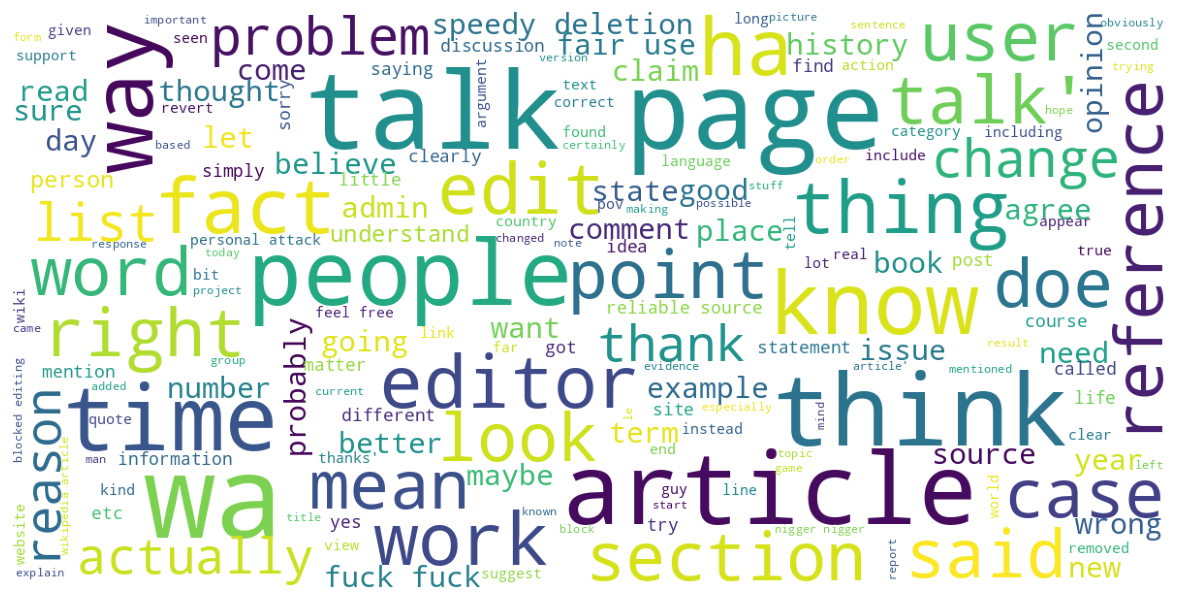

In [44]:
X = []

for word in data['comment_text']:
  X.append(' '.join(word))

wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(X))

fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

#Vectorization

In [45]:
X_text = df['comment_text']

**max_features refers to the word limit**

In [46]:
tfid = TfidfVectorizer(stop_words='english',max_features=1000)

In [47]:
X_data = tfid.fit_transform(X_text)

In [48]:
len(X_data.toarray())

159571

In [49]:
X = X_data.toarray()

In [50]:
X.shape

(159571, 1000)

In [51]:
type(X)

numpy.ndarray

#Normalization

In [52]:
ss = StandardScaler()

X_scaled = ss.fit_transform(X)

In [53]:
X_scaled.shape

(159571, 1000)

In [54]:
X_scaled[:5,:]

array([[-0.06822361, -0.10298515, -0.08159027, ..., -0.13204415,
        -0.12518033, 17.05436304],
       [-0.06822361, -0.10298515, -0.08159027, ..., -0.13204415,
        -0.12518033, -0.05564345],
       [-0.06822361, -0.10298515, -0.08159027, ..., -0.13204415,
        -0.12518033, -0.05564345],
       [-0.06822361, -0.10298515, -0.08159027, ..., -0.13204415,
        -0.12518033, -0.05564345],
       [-0.06822361, -0.10298515, -0.08159027, ..., -0.13204415,
        -0.12518033, -0.05564345]])

#Model Building

In [55]:
y = np.array(df[selected_columns])

In [56]:
y.shape

(159571, 6)

In [57]:
lr = LogisticRegression(max_iter=1000)

In [58]:
k = 5

kf = KFold(n_splits=k,shuffle=True,random_state=42)

In [59]:
cv_scores = []

for i in range(6):
  scores = cross_val_score(estimator=lr,X=X,y=y[:,i],cv=kf)
  cv_scores.append(scores.mean())

In [60]:
np.array(cv_scores).mean()

0.9793790857055967

In [61]:
nb = GaussianNB()

In [62]:
cv_scores_nb = []

for i in range(6):
  scores = cross_val_score(estimator=nb,X=X,y=y[:,i],cv=kf)
  cv_scores_nb.append(scores.mean())

In [63]:
cv_scores_nb

[0.7636412306609184,
 0.7491774726985165,
 0.7679152060030201,
 0.8016557733280745,
 0.751790729964973,
 0.6868541191762905]

#RNN using Spacy

In [64]:
X_new = np.empty(X.shape[0], dtype=object)

for i in range(X.shape[0]):
    X_new[i] = ' '.join(data['comment_text'][i])

In [65]:
X_new[:5]

array(['explanation edits username hardcore metallica fan reverted vandalism closure gas voted new york dolls fac remove template talk page retired',
       'daww match background colour seemingly stuck thanks talk january utc',
       'hey man trying edit war guy constantly removing relevant information talking edits instead talk page care formatting actual info',
       'real suggestion improvement wondered section statistic later subsection type accident think reference need tidying exact format date format etc later doe preference formatting style reference want let know appears backlog article review guess delay reviewer turn listed relevant form wikipedia goodarticlenominations transport',
       'sir hero chance remember page'], dtype=object)

In [66]:
len(X_new)

159571

In [67]:
lengths = np.array([len(l.split(' ')) for l in X_new])

In [68]:
lengths.mean()

29.699017991991028

In [69]:
pad_len = 40

#Tokenization

In [70]:
voc_size = 40000

t = Tokenizer(num_words=voc_size,oov_token="<UNK>")
t.fit_on_texts(X_new)
sequences = t.texts_to_sequences(X_new)

In [71]:
len(sequences), len(sequences[0])

(159571, 20)

In [72]:
word_index = t.word_index

In [73]:
len(word_index)

203358

#Padding

In [74]:
pad_seq = pad_sequences(sequences,maxlen=pad_len,padding='post')

In [75]:
pad_seq.shape

(159571, 40)

#Embedding Matrix

In [76]:
no_of_features = 200
no_of_seq = len(sequences)

embedding_matrix = np.zeros((voc_size,no_of_features))

In [77]:
embedding_matrix.shape

(40000, 200)

In [78]:
for word, i in word_index.items():
    try:
        embedding_matrix[i] = embeddings_index[word]
    except:
      pass

In [79]:
selected_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

y = df[selected_columns]

In [80]:
y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [81]:
y_new = np.array(y)

In [82]:
y_new[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

#Train Test Split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq,y_new,test_size=0.4,random_state=30,shuffle=True)

In [84]:
X_test[0]

array([ 4604,   825, 10534, 10991,   852,   955,   571,     2,  4247,
        7296,     2,   344,  3987,   132,  1769,    58,  7296,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [85]:
len(X_train)

95742

#Neural Network

In [86]:
model = Sequential()

model.add(InputLayer(input_shape=(pad_len,)))
model.add(keras.layers.Embedding(input_dim=voc_size, output_dim=no_of_features, input_length=pad_len,weights=[embedding_matrix],trainable=False))
model.add(LSTM(units=400))
model.add(Dense(units=6,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
epochs = 5
batch_size = 500

lstm_model = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))

Epoch 1/5
192/192 [==============================] - 22s 57ms/step - loss: 0.3469 - accuracy: 0.9819 - val_loss: 0.3588 - val_accuracy: 0.9945
Epoch 2/5
192/192 [==============================] - 10s 50ms/step - loss: 0.3452 - accuracy: 0.9939 - val_loss: 0.3600 - val_accuracy: 0.9945
Epoch 3/5
192/192 [==============================] - 10s 51ms/step - loss: 0.3452 - accuracy: 0.9939 - val_loss: 0.3576 - val_accuracy: 0.9945
Epoch 4/5
192/192 [==============================] - 10s 54ms/step - loss: 0.3452 - accuracy: 0.9939 - val_loss: 0.3597 - val_accuracy: 0.9945
Epoch 5/5
192/192 [==============================] - 10s 54ms/step - loss: 0.3451 - accuracy: 0.9939 - val_loss: 0.3611 - val_accuracy: 0.9945


#Results

In [88]:
train_accuracy = lstm_model.history['accuracy']
test_accuracy = lstm_model.history['val_accuracy']

train_loss = lstm_model.history['loss']
test_loss = lstm_model.history['val_loss']

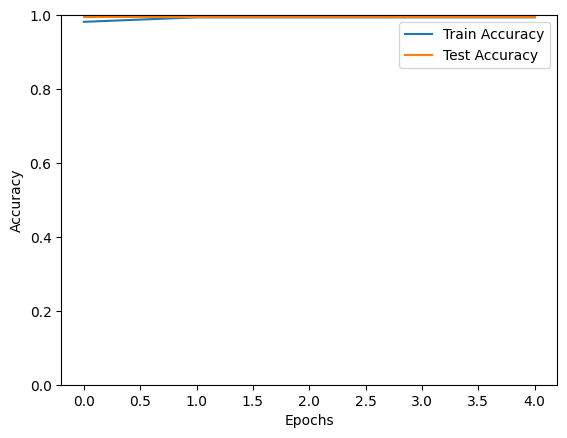

In [89]:
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()
plt.show()

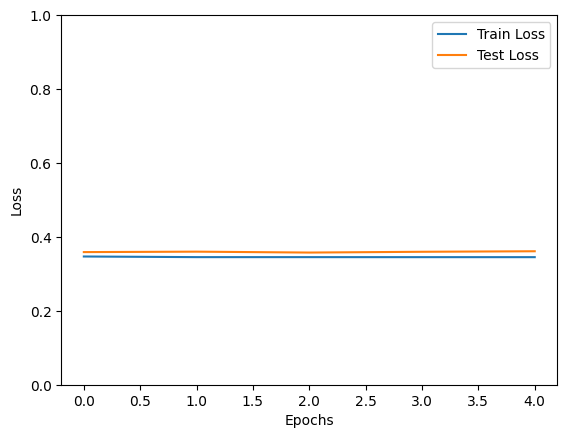

In [90]:
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,1))
plt.legend()
plt.show()